# %% [markdown]
# # Notebook 3: Categorical Features Analysis
# ## Credit Risk Modeling for Bati Bank
# 
# ### Focus: Channel, Product, and Geographic Analysis for Risk Profiling
# 
# **Key Objectives:**
# 1. Analyze categorical features for risk segmentation
# 2. Identify high-risk channels, products, and geographies
# 3. Prepare features for encoding in credit scoring models
# 4. Develop business rules for risk-based decisioning

# %% [markdown]
# ## 1. Setup & Configuration

In [1]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# %%
# Bank styling with corporate colors
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
corporate_colors = ['#003366', '#0066CC', '#0099FF', '#00CCFF', '#66CCFF']  # Blue corporate theme
risk_colors = ['#2E8B57', '#FFD700', '#FF8C00', '#DC143C']  # Green to red risk scale

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("✅ Notebook 3: Categorical Features Analysis")
print("🎯 Focus: Channel, Product, and Geographic Risk Profiling")

✅ Notebook 3: Categorical Features Analysis
🎯 Focus: Channel, Product, and Geographic Risk Profiling


In [3]:
# %%
# Load data - Update path if needed
df = pd.read_csv('../../data/processed/cleaned_data.csv', parse_dates=['TransactionStartTime'])
print(f"📊 Dataset: {df.shape[0]:,} transactions, {df.shape[1]} features")

📊 Dataset: 95,662 transactions, 21 features


# %% [markdown]
# ## 2. Identify Categorical Features

In [4]:
# %%
print("="*80)
print("IDENTIFYING CATEGORICAL FEATURES")
print("="*80)

# Identify categorical columns
categorical_cols = []
for col in df.columns:
    if df[col].dtype == 'object' or df[col].nunique() < 20:  # Consider low-cardinality numerical as categorical
        categorical_cols.append(col)

# Remove datetime columns
datetime_cols = [col for col in categorical_cols if 'Time' in col or 'Date' in col]
categorical_cols = [col for col in categorical_cols if col not in datetime_cols]

print(f"🔤 Found {len(categorical_cols)} categorical features:")
for i, col in enumerate(categorical_cols, 1):
    unique_count = df[col].nunique()
    missing_pct = (df[col].isnull().sum() / len(df)) * 100
    print(f"  {i:2d}. {col:25s} | Unique: {unique_count:5d} | Missing: {missing_pct:5.1f}%")

IDENTIFYING CATEGORICAL FEATURES
🔤 Found 13 categorical features:
   1. TransactionId             | Unique: 95662 | Missing:   0.0%
   2. BatchId                   | Unique: 94809 | Missing:   0.0%
   3. AccountId                 | Unique:  3633 | Missing:   0.0%
   4. SubscriptionId            | Unique:  3627 | Missing:   0.0%
   5. CustomerId                | Unique:  3742 | Missing:   0.0%
   6. CurrencyCode              | Unique:     1 | Missing:   0.0%
   7. CountryCode               | Unique:     1 | Missing:   0.0%
   8. ProviderId                | Unique:     6 | Missing:   0.0%
   9. ProductId                 | Unique:    23 | Missing:   0.0%
  10. ProductCategory           | Unique:     9 | Missing:   0.0%
  11. ChannelId                 | Unique:     4 | Missing:   0.0%
  12. PricingStrategy           | Unique:     4 | Missing:   0.0%
  13. FraudResult               | Unique:     2 | Missing:   0.0%


In [5]:
# %%
# Categorize by business function
categories = {
    'CUSTOMER_IDENTIFIERS': ['CustomerId', 'AccountId', 'SubscriptionId'],
    'TRANSACTION_IDENTIFIERS': ['TransactionId', 'BatchId'],
    'GEOGRAPHIC': ['CountryCode', 'CurrencyCode'],
    'PRODUCT': ['ProductId', 'ProductCategory', 'ProviderId'],
    'CHANNEL': ['ChannelId'],
    'PRICING': ['PricingStrategy'],
    'ENGINEERED': [col for col in categorical_cols if col.endswith('_hour') or col.endswith('_day') or col.endswith('_dayofweek')]
}

# Display categorization
print("\n📋 CATEGORICAL FEATURES BY BUSINESS FUNCTION:")
print("-" * 60)

for category, features in categories.items():
    features_in_data = [f for f in features if f in categorical_cols]
    if features_in_data:
        print(f"{category}:")
        for feature in features_in_data:
            unique_vals = df[feature].nunique()
            print(f"  • {feature} ({unique_vals} unique values)")
        print()


📋 CATEGORICAL FEATURES BY BUSINESS FUNCTION:
------------------------------------------------------------
CUSTOMER_IDENTIFIERS:
  • CustomerId (3742 unique values)
  • AccountId (3633 unique values)
  • SubscriptionId (3627 unique values)

TRANSACTION_IDENTIFIERS:
  • TransactionId (95662 unique values)
  • BatchId (94809 unique values)

GEOGRAPHIC:
  • CountryCode (1 unique values)
  • CurrencyCode (1 unique values)

PRODUCT:
  • ProductId (23 unique values)
  • ProductCategory (9 unique values)
  • ProviderId (6 unique values)

CHANNEL:
  • ChannelId (4 unique values)

PRICING:
  • PricingStrategy (4 unique values)



# %% [markdown]
# ## 3. Channel Analysis - Critical for Fraud Detection

In [6]:
# %%
print("="*80)
print("CHANNEL ANALYSIS - TRANSACTION CHANNEL RISK PROFILING")
print("="*80)

if 'ChannelId' in df.columns:
    channel_data = df['ChannelId'].astype(str)
    
    print("\n📱 CHANNEL DISTRIBUTION:")
    print("-" * 40)
    
    # Channel statistics
    channel_counts = channel_data.value_counts()
    channel_percentages = (channel_counts / len(channel_data)) * 100
    
    for channel, count in channel_counts.items():
        pct = channel_percentages[channel]
        print(f"  {channel:15s}: {count:7,} transactions ({pct:5.1f}%)")

CHANNEL ANALYSIS - TRANSACTION CHANNEL RISK PROFILING

📱 CHANNEL DISTRIBUTION:
----------------------------------------
  ChannelId_3    :  56,935 transactions ( 59.5%)
  ChannelId_2    :  37,141 transactions ( 38.8%)
  ChannelId_5    :   1,048 transactions (  1.1%)
  ChannelId_1    :     538 transactions (  0.6%)


In [8]:
# %%
# Fraud analysis by channel
if 'ChannelId' in df.columns and 'FraudResult' in df.columns:
    print("\n🚨 FRAUD ANALYSIS BY CHANNEL:")
    print("-" * 40)
    
    fraud_by_channel = df.groupby('ChannelId')['FraudResult'].agg(['count', 'sum', 'mean'])
    fraud_by_channel['fraud_rate'] = fraud_by_channel['mean'] * 100
    fraud_by_channel['fraud_risk'] = pd.qcut(fraud_by_channel['fraud_rate'], 
                                             q=4, labels=['Low', 'Medium', 'High', 'Very High'])
    
    # Display with risk assessment
    for channel in fraud_by_channel.index:
        stats = fraud_by_channel.loc[channel]
        risk_level = stats['fraud_risk']
        risk_color = {'Low': '🟢', 'Medium': '🟡', 'High': '🟠', 'Very High': '🔴'}[risk_level]
        
        print(f"  {channel:15s}: {stats['sum']:3.0f} frauds | {stats['fraud_rate']:5.2f}% rate | {risk_color} {risk_level} Risk")
else:
    if 'ChannelId' not in df.columns:
        print("❌ 'ChannelId' column not found in dataframe")
    if 'FraudResult' not in df.columns:
        print("❌ 'FraudResult' column not found in dataframe")


🚨 FRAUD ANALYSIS BY CHANNEL:
----------------------------------------


  ChannelId_1    :   4 frauds |  0.74% rate | 🔴 Very High Risk
  ChannelId_2    :   5 frauds |  0.01% rate | 🟡 Medium Risk
  ChannelId_3    : 184 frauds |  0.32% rate | 🟠 High Risk
  ChannelId_5    :   0 frauds |  0.00% rate | 🟢 Low Risk


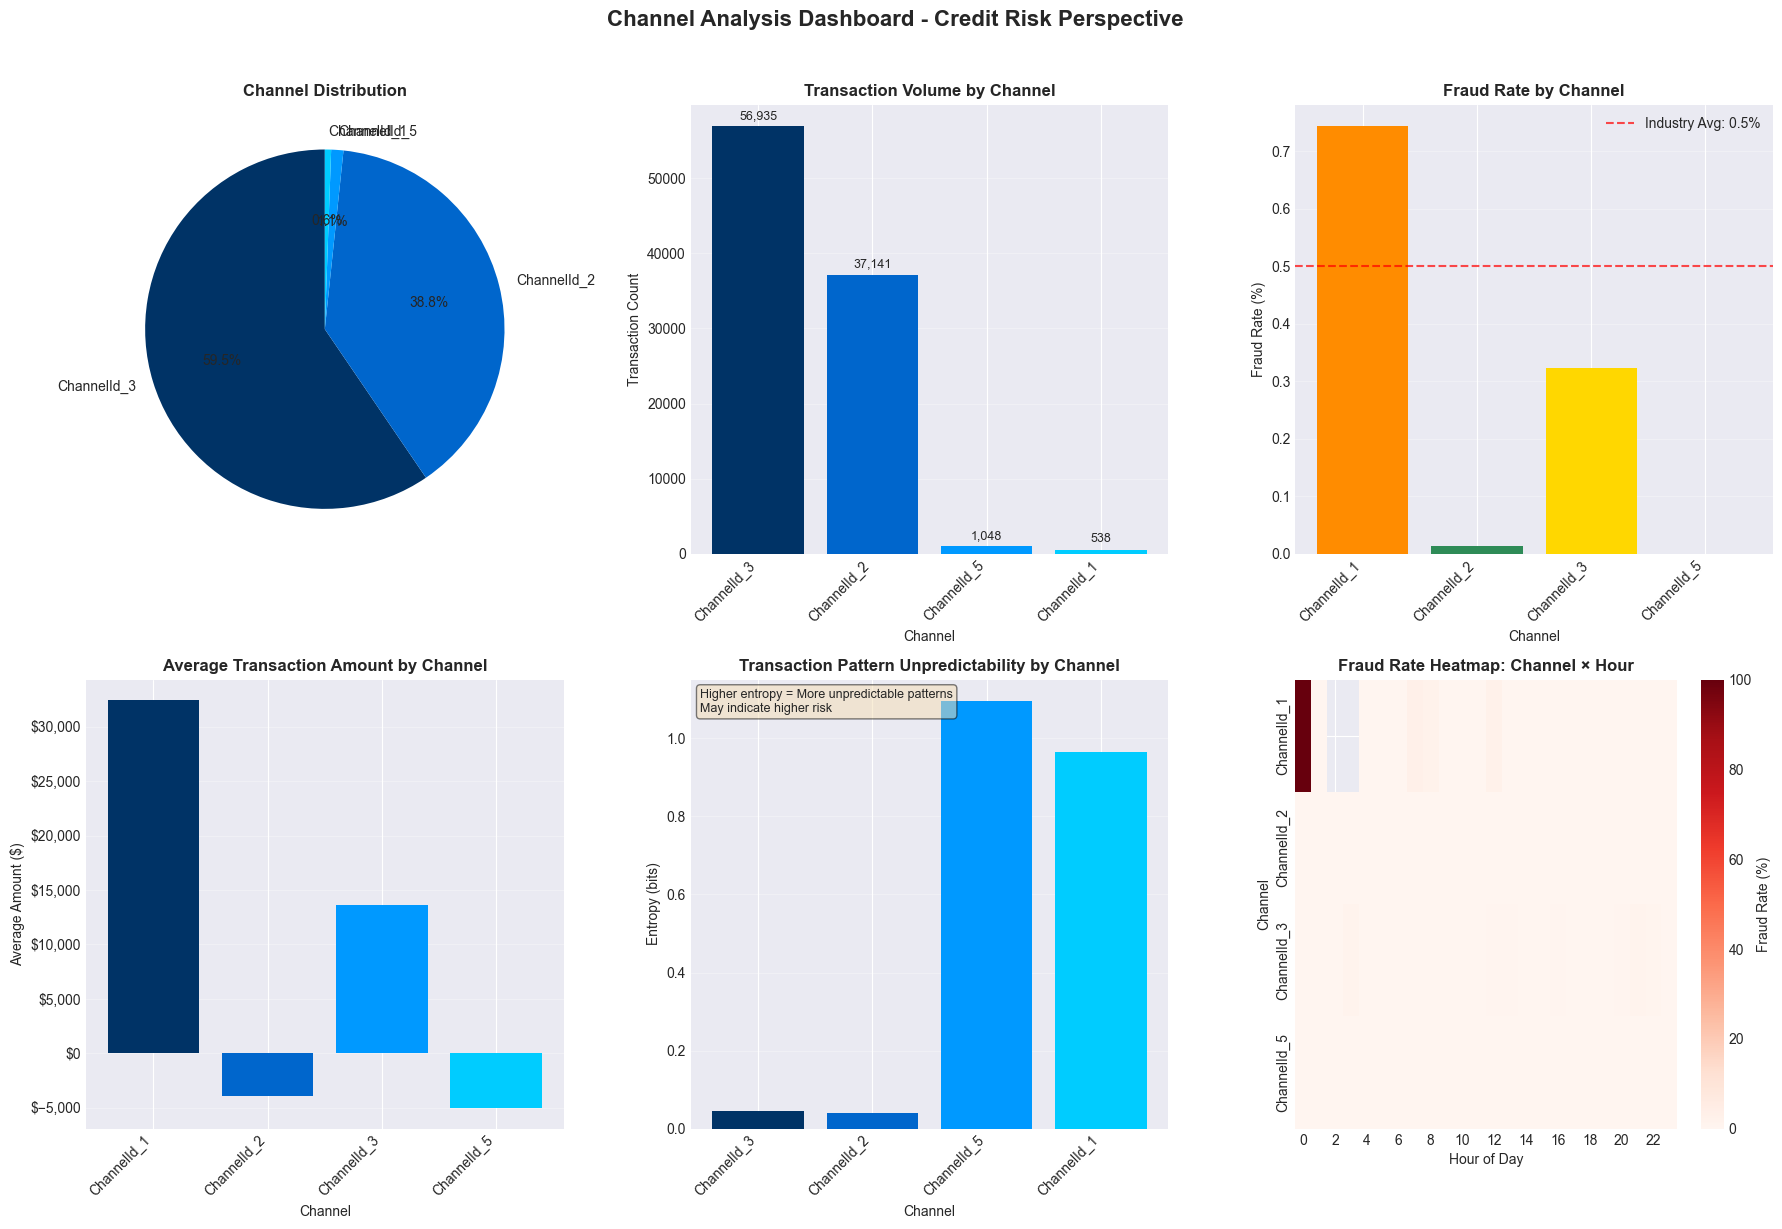

✅ Created complete channel dashboard with 6 subplots
📁 Saved to: ../../reports/task2_eda/visualizations/categorical/channel_analysis.png


In [17]:
# %%
# Create comprehensive channel dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Channel distribution pie chart
ax1 = axes[0, 0]
wedges, texts, autotexts = ax1.pie(channel_counts.values, labels=channel_counts.index,
                                   autopct='%1.1f%%', startangle=90, colors=corporate_colors)
ax1.set_title('Channel Distribution', fontsize=12, fontweight='bold')

# 2. Transaction volume by channel
ax2 = axes[0, 1]
bars = ax2.bar(range(len(channel_counts)), channel_counts.values, color=corporate_colors)
ax2.set_xlabel('Channel')
ax2.set_ylabel('Transaction Count')
ax2.set_title('Transaction Volume by Channel', fontsize=12, fontweight='bold')
ax2.set_xticks(range(len(channel_counts)))
ax2.set_xticklabels(channel_counts.index, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, count in zip(bars, channel_counts.values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(channel_counts.values)*0.01,
            f'{count:,}', ha='center', va='bottom', fontsize=9)

# 3. Fraud rate by channel (if available)
if 'FraudResult' in df.columns:
    ax3 = axes[0, 2]
    
    fraud_rates = fraud_by_channel['fraud_rate']
    colors = []
    for rate in fraud_rates:
        if rate < 0.1:
            colors.append(risk_colors[0])  # Green
        elif rate < 0.5:
            colors.append(risk_colors[1])  # Yellow
        elif rate < 1.0:
            colors.append(risk_colors[2])  # Orange
        else:
            colors.append(risk_colors[3])  # Red
    
    bars = ax3.bar(range(len(fraud_rates)), fraud_rates, color=colors)
    ax3.set_xlabel('Channel')
    ax3.set_ylabel('Fraud Rate (%)')
    ax3.set_title('Fraud Rate by Channel', fontsize=12, fontweight='bold')
    ax3.set_xticks(range(len(fraud_rates)))
    ax3.set_xticklabels(fraud_rates.index, rotation=45, ha='right')
    ax3.grid(axis='y', alpha=0.3)
    
    # Add industry benchmark line
    industry_avg = 0.5  # Typical e-commerce fraud rate
    ax3.axhline(y=industry_avg, color='red', linestyle='--', alpha=0.7, 
               label=f'Industry Avg: {industry_avg:.1f}%')
    ax3.legend()
else:
    # If no fraud data, create placeholder
    ax3 = axes[0, 2]
    ax3.text(0.5, 0.5, 'Fraud data not available\nfor this analysis', 
            ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Fraud Rate by Channel', fontsize=12, fontweight='bold')
    ax3.set_xticks([])
    ax3.set_yticks([])

# 4. Average transaction amount by channel
if 'Amount' in df.columns:
    ax4 = axes[1, 0]
    avg_amount_by_channel = df.groupby('ChannelId')['Amount'].mean()
    
    bars = ax4.bar(range(len(avg_amount_by_channel)), avg_amount_by_channel.values, 
                  color=corporate_colors)
    ax4.set_xlabel('Channel')
    ax4.set_ylabel('Average Amount ($)')
    ax4.set_title('Average Transaction Amount by Channel', fontsize=12, fontweight='bold')
    ax4.set_xticks(range(len(avg_amount_by_channel)))
    ax4.set_xticklabels(avg_amount_by_channel.index, rotation=45, ha='right')
    ax4.grid(axis='y', alpha=0.3)
    
    # Format y-axis as currency
    import matplotlib.ticker as ticker
    ax4.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
else:
    # If no amount data, create placeholder
    ax4 = axes[1, 0]
    ax4.text(0.5, 0.5, 'Amount data not available\nfor this analysis', 
            ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Average Amount by Channel', fontsize=12, fontweight='bold')
    ax4.set_xticks([])
    ax4.set_yticks([])

# 5. Channel entropy analysis
ax5 = axes[1, 1]

# Calculate entropy for each channel (measure of unpredictability)
channel_entropy = {}
for channel in channel_counts.index:
    channel_transactions = df[df['ChannelId'] == channel]
    if 'Amount' in df.columns and len(channel_transactions) > 0:
        # Discretize amounts into bins
        amounts = channel_transactions['Amount']
        hist, _ = np.histogram(amounts, bins=20)
        hist = hist[hist > 0]
        if len(hist) > 0:
            probabilities = hist / hist.sum()
            entropy = -np.sum(probabilities * np.log2(probabilities))
            channel_entropy[channel] = entropy

if channel_entropy:
    channels = list(channel_entropy.keys())
    entropies = list(channel_entropy.values())
    
    bars = ax5.bar(range(len(channels)), entropies, color=corporate_colors)
    ax5.set_xlabel('Channel')
    ax5.set_ylabel('Entropy (bits)')
    ax5.set_title('Transaction Pattern Unpredictability by Channel', fontsize=12, fontweight='bold')
    ax5.set_xticks(range(len(channels)))
    ax5.set_xticklabels(channels, rotation=45, ha='right')
    ax5.grid(axis='y', alpha=0.3)
    
    ax5.text(0.02, 0.98, 'Higher entropy = More unpredictable patterns\nMay indicate higher risk',
            transform=ax5.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
else:
    # If entropy cannot be calculated
    ax5 = axes[1, 1]
    ax5.text(0.5, 0.5, 'Entropy analysis not possible\n(insufficient data)', 
            ha='center', va='center', transform=ax5.transAxes)
    ax5.set_title('Pattern Unpredictability', fontsize=12, fontweight='bold')
    ax5.set_xticks([])
    ax5.set_yticks([])

# 6. Risk heatmap (Channel × Time)
if 'TransactionStartTime_hour' in df.columns:
    ax6 = axes[1, 2]
    
    # Create heatmap data
    if 'FraudResult' in df.columns:
        heatmap_data = pd.crosstab(df['ChannelId'], df['TransactionStartTime_hour'], 
                                  values=df['FraudResult'], aggfunc='mean')
        sns.heatmap(heatmap_data * 100, ax=ax6, cmap='Reds', 
                   cbar_kws={'label': 'Fraud Rate (%)'})
        ax6.set_title('Fraud Rate Heatmap: Channel × Hour', fontsize=12, fontweight='bold')
    else:
        heatmap_data = pd.crosstab(df['ChannelId'], df['TransactionStartTime_hour'])
        sns.heatmap(heatmap_data, ax=ax6, cmap='Blues', 
                   cbar_kws={'label': 'Transaction Count'})
        ax6.set_title('Transaction Volume Heatmap: Channel × Hour', fontsize=12, fontweight='bold')
    
    ax6.set_xlabel('Hour of Day')
    ax6.set_ylabel('Channel')
else:
    # If no time data, create placeholder
    ax6 = axes[1, 2]
    ax6.text(0.5, 0.5, 'Time data not available\nfor heatmap analysis', 
            ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('Channel × Time Heatmap', fontsize=12, fontweight='bold')
    ax6.set_xticks([])
    ax6.set_yticks([])

plt.suptitle('Channel Analysis Dashboard - Credit Risk Perspective', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Save figure
import os
save_dir = '../../reports/task2_eda/visualizations/categorical/'
os.makedirs(save_dir, exist_ok=True)

plt.savefig(os.path.join(save_dir, 'channel_analysis.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Created complete channel dashboard with 6 subplots")
print(f"📁 Saved to: {os.path.join(save_dir, 'channel_analysis.png')}")

# %% [markdown]
# ## 4. Product Category Analysis

In [18]:
# %%
print("="*80)
print("PRODUCT CATEGORY ANALYSIS - PRODUCT RISK PROFILING")
print("="*80)

if 'ProductCategory' in df.columns:
    product_data = df['ProductCategory'].astype(str)
    
    print("\n🛍️ PRODUCT CATEGORY DISTRIBUTION:")
    print("-" * 40)
    
    # Product category statistics
    product_counts = product_data.value_counts()
    product_percentages = (product_counts / len(product_data)) * 100
    
    for product, count in product_counts.items():
        pct = product_percentages[product]
        print(f"  {product:20s}: {count:7,} transactions ({pct:5.1f}%)")

PRODUCT CATEGORY ANALYSIS - PRODUCT RISK PROFILING

🛍️ PRODUCT CATEGORY DISTRIBUTION:
----------------------------------------
  financial_services  :  45,405 transactions ( 47.5%)
  airtime             :  45,027 transactions ( 47.1%)
  utility_bill        :   1,920 transactions (  2.0%)
  data_bundles        :   1,613 transactions (  1.7%)
  tv                  :   1,279 transactions (  1.3%)
  ticket              :     216 transactions (  0.2%)
  movies              :     175 transactions (  0.2%)
  transport           :      25 transactions (  0.0%)
  other               :       2 transactions (  0.0%)


In [20]:
# %%
# Financial analysis by product category
if 'ProductCategory' in df.columns and 'Amount' in df.columns:
    print("\n💰 FINANCIAL ANALYSIS BY PRODUCT CATEGORY:")
    print("-" * 40)
    
    financial_by_product = df.groupby('ProductCategory')['Amount'].agg([
        'count', 'sum', 'mean', 'std', 'min', 'max'
    ])
    financial_by_product.columns = ['transactions', 'total_value', 'avg_value', 
                                   'std_value', 'min_value', 'max_value']
    
    # Calculate value concentration
    total_value_all = financial_by_product['total_value'].sum()
    financial_by_product['value_share'] = (financial_by_product['total_value'] / total_value_all) * 100
    
    # Display top categories by value
    top_by_value = financial_by_product.nlargest(5, 'total_value')
    print("  Top 5 Categories by Transaction Value:")
    for idx, (product, row) in enumerate(top_by_value.iterrows(), 1):
        print(f"    {idx}. {product:20s}: ${row['total_value']:,.0f} ({row['value_share']:.1f}% of total)")
else:
    if 'ProductCategory' not in df.columns:
        print("❌ 'ProductCategory' column not found in dataframe")
    if 'Amount' not in df.columns:
        print("❌ 'Amount' column not found in dataframe")


💰 FINANCIAL ANALYSIS BY PRODUCT CATEGORY:
----------------------------------------
  Top 5 Categories by Transaction Value:
    1. financial_services  : $519,231,578 (80.8% of total)
    2. airtime             : $37,055,259 (5.8% of total)
    3. utility_bill        : $33,087,089 (5.1% of total)
    4. tv                  : $21,284,000 (3.3% of total)
    5. ticket              : $20,886,500 (3.3% of total)


In [23]:
# %%
# Fraud analysis by product category
if 'FraudResult' in df.columns:
    print("\n🚨 FRAUD ANALYSIS BY PRODUCT CATEGORY:")
    print("-" * 40)
    
    fraud_by_product = df.groupby('ProductCategory')['FraudResult'].agg(['count', 'sum', 'mean'])
    fraud_by_product['fraud_rate'] = fraud_by_product['mean'] * 100
    fraud_by_product = fraud_by_product.sort_values('fraud_rate', ascending=False)
    
    # Risk categorization - FIXED VERSION
    # Check if we have enough unique values for qcut
    unique_fraud_rates = fraud_by_product['fraud_rate'].nunique()
    
    if unique_fraud_rates >= 4:
        # We have enough unique values for 4 quantiles
        try:
            fraud_by_product['risk_level'] = pd.qcut(
                fraud_by_product['fraud_rate'], 
                q=4, 
                labels=['Low', 'Medium', 'High', 'Very High'],
                duplicates='drop'  # This handles duplicate values
            )
        except:
            # If qcut still fails, use custom bins
            fraud_by_product['risk_level'] = pd.cut(
                fraud_by_product['fraud_rate'],
                bins=[-1, 0.1, 0.5, 1.0, float('inf')],
                labels=['Low', 'Medium', 'High', 'Very High']
            )
    else:
        # Not enough unique values, use simpler categorization
        if unique_fraud_rates == 1:
            # All products have same fraud rate
            fraud_by_product['risk_level'] = 'Medium'
        else:
            # Use custom bins based on available values
            fraud_by_product['risk_level'] = pd.cut(
                fraud_by_product['fraud_rate'],
                bins=pd.cut(fraud_by_product['fraud_rate'], bins=unique_fraud_rates),
                labels=['Low'] + ['Medium'] * (unique_fraud_rates - 2) + ['High']
            )
    
    print("  Fraud Rates by Product Category:")
    for product in fraud_by_product.index[:10]:  # Top 10 by fraud rate
        stats = fraud_by_product.loc[product]
        # Handle risk_level if it's not a string
        if isinstance(stats['risk_level'], (pd.Categorical, pd.Series, pd.Interval)):
            risk_icon = '🟡'  # Default to medium
        else:
            risk_level_str = str(stats['risk_level'])
            risk_icon = {'Low': '🟢', 'Medium': '🟡', 'High': '🟠', 'Very High': '🔴'}.get(risk_level_str, '🟡')
        
        print(f"    {risk_icon} {product:20s}: {stats['fraud_rate']:5.2f}% ({stats['sum']:.0f} frauds)")


🚨 FRAUD ANALYSIS BY PRODUCT CATEGORY:
----------------------------------------
  Fraud Rates by Product Category:
    🔴 transport           :  8.00% (2 frauds)
    🟠 utility_bill        :  0.62% (12 frauds)
    🟡 financial_services  :  0.35% (161 frauds)
    🟢 airtime             :  0.04% (18 frauds)
    🟢 data_bundles        :  0.00% (0 frauds)
    🟢 other               :  0.00% (0 frauds)
    🟢 movies              :  0.00% (0 frauds)
    🟢 ticket              :  0.00% (0 frauds)
    🟢 tv                  :  0.00% (0 frauds)


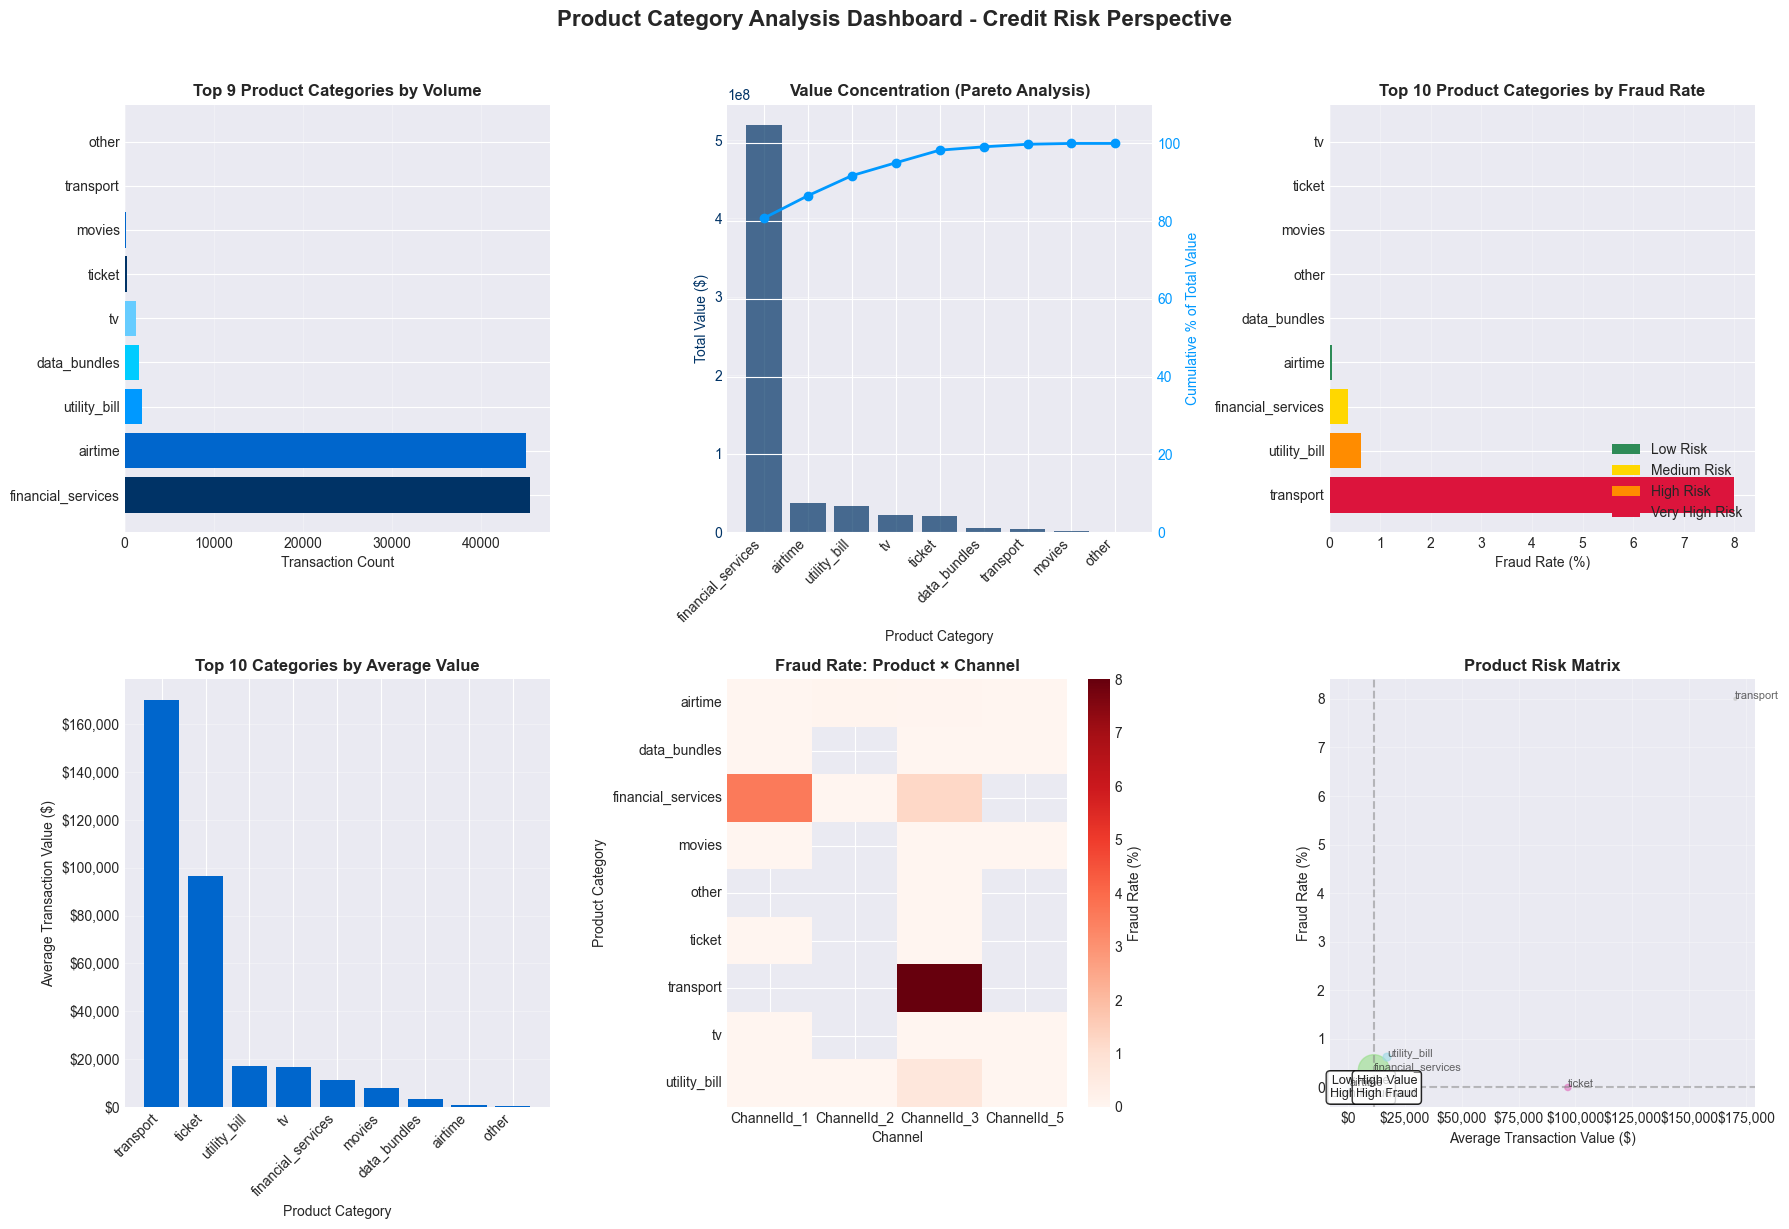


🎯 PRODUCT RISK RECOMMENDATIONS:
------------------------------------------------------------
🔴 HIGH-RISK PRODUCT CATEGORIES:
  • transport: 8.00% fraud rate | Avg value: $170,240.00
    ⚠️  High-value high-risk: Consider manual review for large transactions
  • utility_bill: 0.62% fraud rate | Avg value: $17,232.86
    ⚠️  High-value high-risk: Consider manual review for large transactions


In [28]:
# Create product category dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Product category distribution
ax1 = axes[0, 0]
top_n = min(10, len(product_counts))
top_products = product_counts.head(top_n)

bars = ax1.barh(range(len(top_products)), top_products.values, color=corporate_colors)
ax1.set_yticks(range(len(top_products)))
ax1.set_yticklabels(top_products.index)
ax1.set_xlabel('Transaction Count')
ax1.set_title(f'Top {top_n} Product Categories by Volume', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. Value concentration (Pareto chart)
if 'Amount' in df.columns:
    ax2 = axes[0, 1]
    
    # Sort by total value
    value_by_product = financial_by_product.sort_values('total_value', ascending=False)
    top_n_value = min(10, len(value_by_product))
    
    # Bar chart for value
    bars1 = ax2.bar(range(top_n_value), 
                   value_by_product['total_value'].head(top_n_value), 
                   color=corporate_colors[0], alpha=0.7, label='Total Value')
    ax2.set_xlabel('Product Category')
    ax2.set_ylabel('Total Value ($)', color=corporate_colors[0])
    ax2.set_xticks(range(top_n_value))
    ax2.set_xticklabels(value_by_product.index[:top_n_value], rotation=45, ha='right')
    ax2.tick_params(axis='y', labelcolor=corporate_colors[0])
    ax2.grid(axis='y', alpha=0.3)
    
    # Pareto line
    ax2_secondary = ax2.twinx()
    cumulative_pct = value_by_product['value_share'].head(top_n_value).cumsum()
    ax2_secondary.plot(range(top_n_value), cumulative_pct, 
                      color=corporate_colors[2], linewidth=2, marker='o', label='Cumulative %')
    ax2_secondary.set_ylabel('Cumulative % of Total Value', color=corporate_colors[2])
    ax2_secondary.tick_params(axis='y', labelcolor=corporate_colors[2])
    ax2_secondary.set_ylim(0, 110)
    
    ax2.set_title('Value Concentration (Pareto Analysis)', fontsize=12, fontweight='bold')

# 3. Fraud rate by product (if available)
if 'FraudResult' in df.columns:
    ax3 = axes[0, 2]
    
    top_fraud_products = fraud_by_product.head(10)
    
    colors = []
    for risk in top_fraud_products['risk_level']:
        colors.append({'Low': risk_colors[0], 'Medium': risk_colors[1], 
                      'High': risk_colors[2], 'Very High': risk_colors[3]}[risk])
    
    bars = ax3.barh(range(len(top_fraud_products)), top_fraud_products['fraud_rate'], color=colors)
    ax3.set_yticks(range(len(top_fraud_products)))
    ax3.set_yticklabels(top_fraud_products.index)
    ax3.set_xlabel('Fraud Rate (%)')
    ax3.set_title('Top 10 Product Categories by Fraud Rate', fontsize=12, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3)
    
    # Add risk legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=risk_colors[0], label='Low Risk'),
        Patch(facecolor=risk_colors[1], label='Medium Risk'),
        Patch(facecolor=risk_colors[2], label='High Risk'),
        Patch(facecolor=risk_colors[3], label='Very High Risk')
    ]
    ax3.legend(handles=legend_elements, loc='lower right')

# 4. Average transaction value by product
if 'Amount' in df.columns:
    ax4 = axes[1, 0]
    
    avg_value_sorted = financial_by_product.sort_values('avg_value', ascending=False).head(10)
    
    bars = ax4.bar(range(len(avg_value_sorted)), avg_value_sorted['avg_value'], 
                  color=corporate_colors[1])
    ax4.set_xlabel('Product Category')
    ax4.set_ylabel('Average Transaction Value ($)')
    ax4.set_title('Top 10 Categories by Average Value', fontsize=12, fontweight='bold')
    ax4.set_xticks(range(len(avg_value_sorted)))
    ax4.set_xticklabels(avg_value_sorted.index, rotation=45, ha='right')
    ax4.grid(axis='y', alpha=0.3)
    
    # Format as currency
    import matplotlib.ticker as ticker
    ax4.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

# 5. Product category vs channel heatmap
if 'ChannelId' in df.columns:
    ax5 = axes[1, 1]
    
    # Create cross-tabulation
    if 'FraudResult' in df.columns:
        heatmap_data = pd.crosstab(df['ProductCategory'], df['ChannelId'],
                                  values=df['FraudResult'], aggfunc='mean')
        sns.heatmap(heatmap_data * 100, ax=ax5, cmap='Reds',
                   cbar_kws={'label': 'Fraud Rate (%)'})
        ax5.set_title('Fraud Rate: Product × Channel', fontsize=12, fontweight='bold')
    else:
        heatmap_data = pd.crosstab(df['ProductCategory'], df['ChannelId'])
        sns.heatmap(heatmap_data, ax=ax5, cmap='Blues',
                   cbar_kws={'label': 'Transaction Count'})
        ax5.set_title('Transaction Volume: Product × Channel', fontsize=12, fontweight='bold')
    
    ax5.set_xlabel('Channel')
    ax5.set_ylabel('Product Category')

# 6. Product risk matrix (Value vs Fraud Rate)
if 'Amount' in df.columns and 'FraudResult' in df.columns:
    ax6 = axes[1, 2]
    
    # Merge financial and fraud data
    risk_matrix = pd.merge(financial_by_product[['total_value', 'avg_value']],
                          fraud_by_product[['fraud_rate', 'risk_level']],
                          left_index=True, right_index=True)
    
    # Create scatter plot - FIXED VERSION
    # Convert index to numeric codes for coloring
    import numpy as np
    category_codes = np.arange(len(risk_matrix))
    
    scatter = ax6.scatter(risk_matrix['avg_value'], risk_matrix['fraud_rate'],
                         c=category_codes,
                         s=risk_matrix['total_value'] / risk_matrix['total_value'].max() * 500,
                         alpha=0.6, cmap='tab20')
    
    ax6.set_xlabel('Average Transaction Value ($)')
    ax6.set_ylabel('Fraud Rate (%)')
    ax6.set_title('Product Risk Matrix', fontsize=12, fontweight='bold')
    ax6.grid(alpha=0.3)
    
    # Format x-axis as currency
    ax6.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
    
    # Add quadrant lines
    median_value = risk_matrix['avg_value'].median()
    median_fraud = risk_matrix['fraud_rate'].median()
    
    ax6.axvline(x=median_value, color='gray', linestyle='--', alpha=0.5)
    ax6.axhline(y=median_fraud, color='gray', linestyle='--', alpha=0.5)
    
    # Label quadrants
    ax6.text(median_value * 0.5, median_fraud * 0.5, 'Low Value\nLow Fraud', 
            ha='center', va='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax6.text(median_value * 1.5, median_fraud * 0.5, 'High Value\nLow Fraud', 
            ha='center', va='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax6.text(median_value * 0.5, median_fraud * 1.5, 'Low Value\nHigh Fraud', 
            ha='center', va='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax6.text(median_value * 1.5, median_fraud * 1.5, 'High Value\nHigh Fraud', 
            ha='center', va='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add product labels for outliers
    for idx, row in risk_matrix.iterrows():
        if row['fraud_rate'] > median_fraud * 2 or row['avg_value'] > median_value * 2:
            ax6.annotate(idx, (row['avg_value'], row['fraud_rate']), 
                       fontsize=8, alpha=0.7)

plt.suptitle('Product Category Analysis Dashboard - Credit Risk Perspective', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Save figure
import os
save_dir = '../../reports/task2_eda/visualizations/categorical/'
os.makedirs(save_dir, exist_ok=True)

plt.savefig(os.path.join(save_dir, 'product_analysis.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Product risk recommendations
print("\n🎯 PRODUCT RISK RECOMMENDATIONS:")
print("-" * 60)

if 'FraudResult' in df.columns and 'Amount' in df.columns:
    # Identify high-risk products
    high_risk_products = fraud_by_product[fraud_by_product['risk_level'].isin(['High', 'Very High'])]
    
    if not high_risk_products.empty:
        print("🔴 HIGH-RISK PRODUCT CATEGORIES:")
        for product in high_risk_products.index:
            fraud_rate = fraud_by_product.loc[product, 'fraud_rate']
            avg_value = financial_by_product.loc[product, 'avg_value'] if product in financial_by_product.index else 'N/A'
            
            print(f"  • {product}: {fraud_rate:.2f}% fraud rate | Avg value: ${avg_value:,.2f}")
            
            # Specific recommendations based on value
            if isinstance(avg_value, (int, float)):
                if avg_value > 1000:
                    print(f"    ⚠️  High-value high-risk: Consider manual review for large transactions")
                else:
                    print(f"    ⚠️  High-frequency high-risk: Implement velocity checks")
    else:
        print("✅ No product categories with high fraud rates detected")
    
    # Identify high-value low-risk products (opportunity)
    # Note: median_fraud and median_value are defined in the plot section
    # We need to recalculate them here for the recommendations
    if 'risk_matrix' in locals():
        median_value_rec = risk_matrix['avg_value'].median()
        median_fraud_rec = risk_matrix['fraud_rate'].median()
        
        opportunity_products = risk_matrix[
            (risk_matrix['fraud_rate'] < median_fraud_rec) & 
            (risk_matrix['avg_value'] > median_value_rec)
        ]
        
        if not opportunity_products.empty:
            print("\n🟢 HIGH-VALUE LOW-RISK OPPORTUNITIES:")
            for product, row in opportunity_products.iterrows():
                print(f"  • {product}: ${row['avg_value']:,.0f} avg | {row['fraud_rate']:.2f}% fraud")
                print(f"    💡 Opportunity: Offer higher credit limits, promotional financing")